## Rep Table

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # HP filter and OLS regression
import datetime
import subprocess
from datetime import datetime as dt
import matplotlib.dates as mdates
import importlib
from pandas_datareader.fred import FredReader


In [2]:
import data_load_table

Load Data

In [3]:
series = data_load_table.get_fred_data('Q','own_def')

In [4]:
# correct for date offset
series['CO_level'] = series['CO_level'].shift(-1)

View Series

In [5]:
series = series.loc['1985-3-31':'2017-12-31']
series.tail()
series

,Y,Y_nominal,C,G,I,N,CO_rate,D,W_manu,PCE,...,BK,CO_level,D_nominal,BG_nominal,tax_nominal,W_manu_nominal,Piw_manu_perc,D/Y,BG/Y,BK/N
date,,,,,,,,,,,,,,,,,,,,,
1985-03-31,8.400820e+12,4.230168e+12,2.480560e+12,2.120284e+12,1.169416e+12,9.657233e+07,0.82,5.189322e+11,8.745295,49.543333,...,421196.00,9.872354e+08,5.514520e+11,1.710731e+12,3.530180e+11,9.293333,4.068682,13.036173,40.441207,0.436146
1985-06-30,8.474787e+12,4.294887e+12,2.500868e+12,2.167338e+12,1.189334e+12,9.726967e+07,0.97,5.327541e+11,8.737955,49.945000,...,445788.75,1.218759e+09,5.712900e+11,1.774640e+12,3.075820e+11,9.370000,4.111111,13.301631,41.319830,0.458302
1985-09-30,8.604220e+12,4.386773e+12,2.552500e+12,2.216743e+12,1.181226e+12,9.784433e+07,1.15,5.492326e+11,8.739574,50.337000,...,470381.50,1.464762e+09,5.926220e+11,1.823103e+12,3.400300e+11,9.430000,3.778430,13.509293,41.559091,0.480745
1985-12-31,8.668188e+12,4.444094e+12,2.549908e+12,2.225878e+12,1.224763e+12,9.842833e+07,1.28,5.601596e+11,8.715596,50.687667,...,494974.25,2.006145e+09,6.105740e+11,1.945942e+12,3.451820e+11,9.500000,3.410740,13.738998,43.787148,0.502878
1986-03-31,8.749127e+12,4.507894e+12,2.577105e+12,2.243464e+12,1.224404e+12,9.883767e+07,1.35,5.699042e+11,8.722239,51.046667,...,519567.00,1.808710e+09,6.244250e+11,1.986816e+12,3.418250e+11,9.556667,2.833572,13.851812,44.074151,0.525677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,1.930435e+13,1.908938e+13,5.336695e+12,3.389649e+12,3.391749e+12,1.452223e+08,2.11,1.501824e+12,8.507662,98.946667,...,790505.00,8.035290e+09,3.636436e+12,1.997683e+13,1.574500e+12,20.600000,2.640757,19.049525,104.648910,0.544341
2017-03-31,1.939834e+13,1.928008e+13,5.371300e+12,3.380244e+12,3.382703e+12,1.458200e+08,2.19,1.511568e+12,8.470081,99.524000,...,789020.00,8.501728e+09,3.685787e+12,1.984642e+13,1.579976e+12,20.653333,2.210492,19.117069,102.937415,0.541092
2017-06-30,1.950695e+13,1.943864e+13,5.402560e+12,3.389811e+12,3.435929e+12,1.463833e+08,2.11,1.526723e+12,8.519034,99.724333,...,789020.00,7.949218e+09,3.727037e+12,1.984455e+13,1.600122e+12,20.796667,1.827975,19.173339,102.088165,0.539009


In [6]:
# un comment if extending timeframe to zero out vars with NaN values 

# for column in series.columns:
#     if series[column].isna().any():
#         series[column] = 0


Apply HP filter

In [7]:
# Initialize dictionaries to store the cycle and trend components
cycle_components = {}
trend_components = {}

for name, data in series.items():
    # Apply the HP filter to each series
    cycle, trend = sm.tsa.filters.hpfilter(np.log(data).dropna(), 1600)
    
    # Store the cycle and trend components in their respective dictionaries
    cycle_components[name + '_cycle'] = cycle
    trend_components[name + '_trend'] = trend



## New Table

## Combined HP+RAW 

In [8]:
# create rate vars 

series['CPI_rate']=series['CPI'].pct_change(4)*100
series['PCE_rate']=series['PCE'].pct_change(4)*100

In [9]:
# identify var placements in the data frame

top_vars = ['Y', 'C', 'G', 'I', 'N', 'D', 'BG', 'W_manu', 'W_manu_nominal', 'tax', 'BK', 'CO_level', 'CPI', 'PCE']  # Example top variables
bottom_vars = ['CPI_rate', 'PCE_rate', 'i', 'Piw_manu_perc', 'CO_rate','BK/N', 'BG/Y', 'D/Y']  # Example bottom variables
combined_results_list = [] 

In [10]:

# rename CPI rate to make pretty 
series['CPI Rate']=series['CPI_rate']

# Apply HP filter to top variables and store Y's cycle for correlation
cycle_components = {}
for var in top_vars:
    data = np.log(series[var].dropna())  # Taking log of data
    cycle, _ = sm.tsa.filters.hpfilter(data, 1600)
    cycle_components[var] = cycle

y_cycle = cycle_components['Y']  # Extracted cyclical component of 'Y' for correlation

# HP filtered top variables
for var, cycle in cycle_components.items():
    sd = cycle.std()*100
    cor_y_x = cycle.corr(y_cycle)
    cor_x_xt_minus_1 = cycle.corr(cycle.shift(4))
    
    combined_results_list.append({
        'Variable': var, 'SD': sd, 'Cor(y, x)': cor_y_x, 'Cor(x, x_t-4)': cor_x_xt_minus_1
    })

# No Filter bottom variables but correlate with HP filtered 'Y' cycle
for var in bottom_vars:
    data = series[var]  # Not applying HP filter to bottom variables
    sd = data.std()
    cor_y_cycle_x = data.corr(y_cycle)  # Correlating with HP filtered 'Y'
    cor_x_xt_minus_1 = data.corr(data.shift(4))
    
    combined_results_list.append({
        'Variable': var, 'SD': sd, 'Cor(y, x)': cor_y_cycle_x, 'Cor(x, x_t-4)': cor_x_xt_minus_1
    })

# Create DataFrame from the list
combined_results = pd.DataFrame(combined_results_list)
combined_results.set_index('Variable', inplace=True)
combined_results.sort_index(inplace=True)


In [11]:
combined_results

,SD,"Cor(y, x)","Cor(x, x_t-4)"
Variable,,,
BG,2.372258,-0.393554,0.372025
BG/Y,18.645876,-0.131001,0.982507
BK,14.255680,-0.495734,0.213386
BK/N,0.260121,-0.353061,0.729148
C,0.927177,0.853016,0.330995
CO_level,18.124560,-0.559138,0.458538
CO_rate,1.050760,-0.399883,0.755138
CPI,0.711076,0.165906,0.122605
CPI_rate,1.315480,0.398691,0.341219


## Graphs

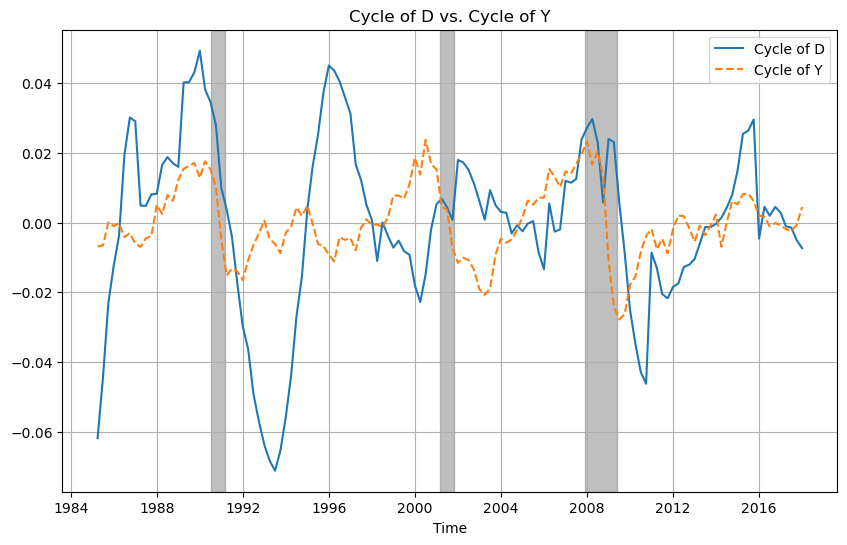

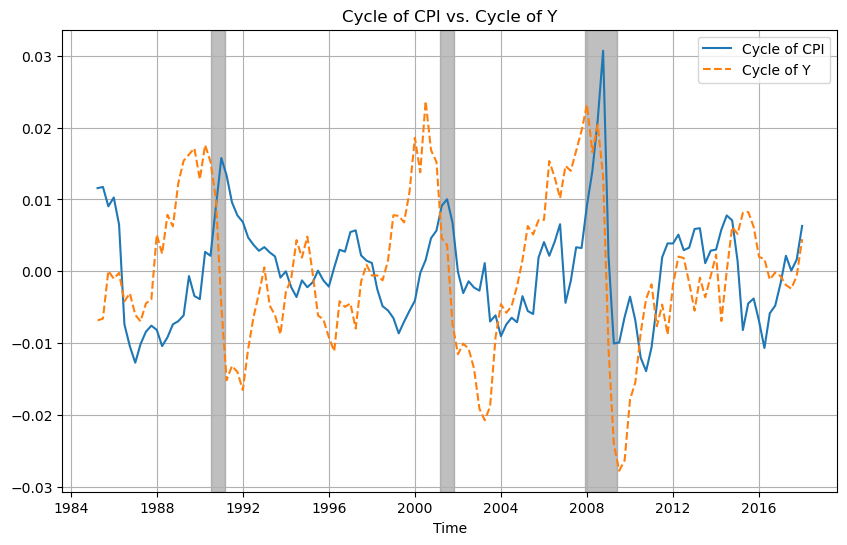

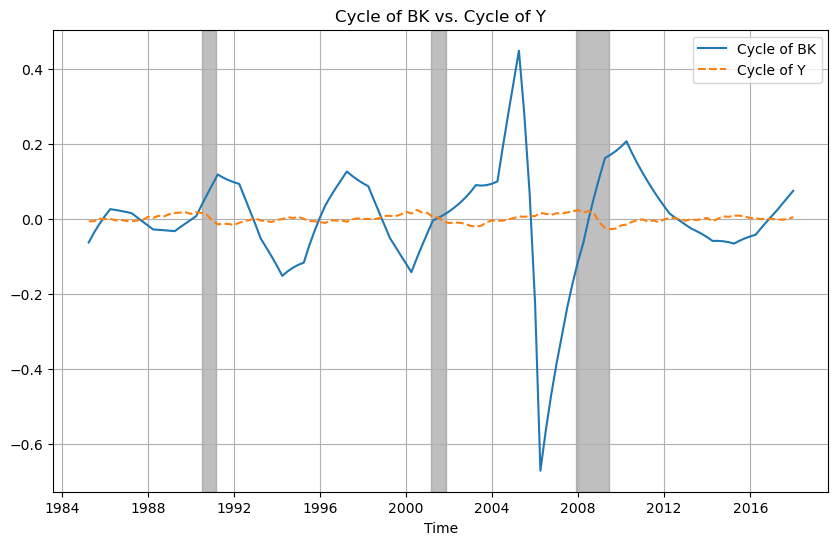

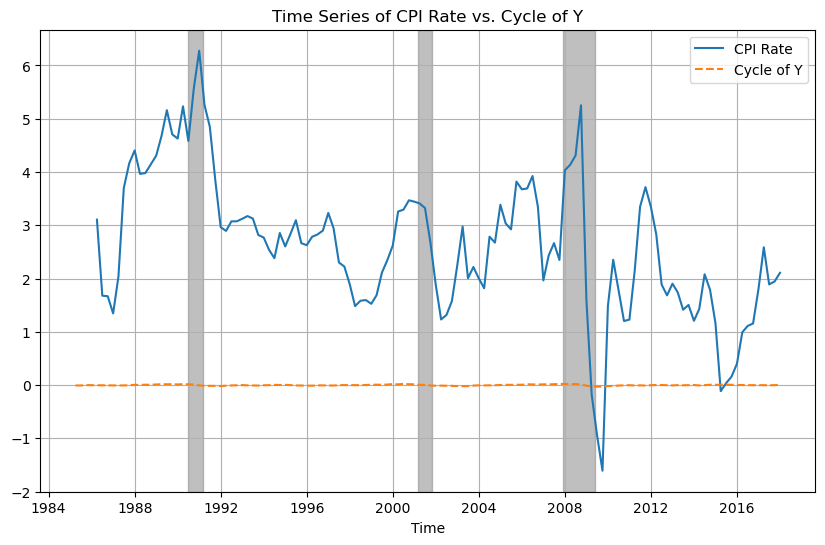

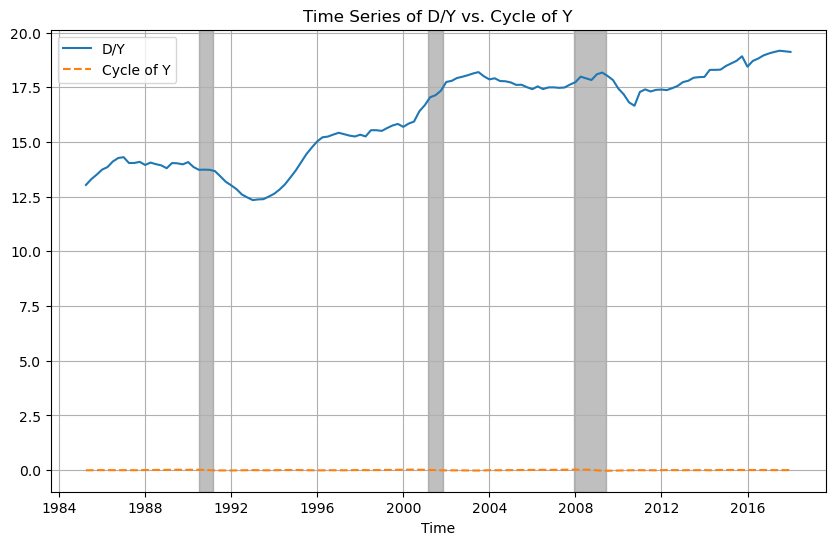

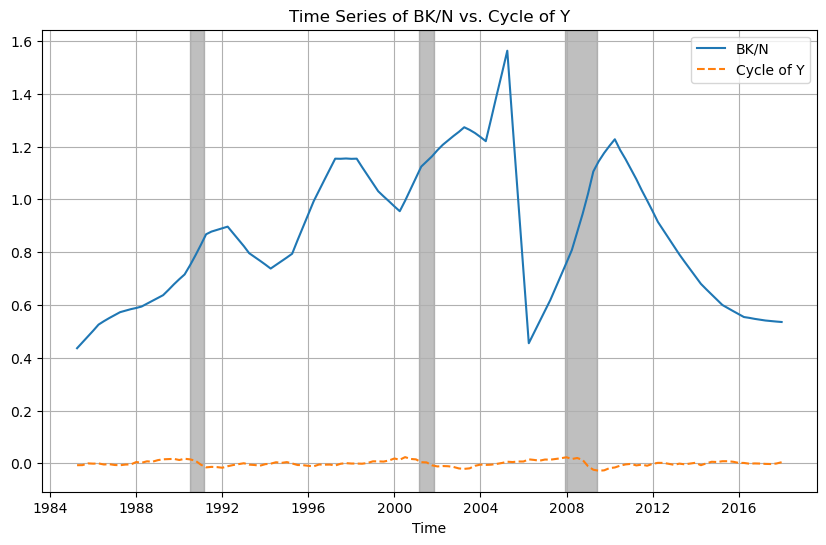

In [12]:
recession_periods = [
('1990-07-01', '1991-03-01'),
('2001-03-01', '2001-11-01'),
('2007-12-01', '2009-06-01'),
]

def plot_time_series_over_time(variable, cycle=False, save_path=None):
    plt.figure(figsize=(10, 6))
    
    if cycle:
        plt.plot(cycle_components[variable].index, cycle_components[variable], label=f'Cycle of {variable}')
        plt.plot(cycle_components['Y'].index, cycle_components['Y'], label='Cycle of Y', linestyle='--')
        plt.title(f'Cycle of {variable} vs. Cycle of Y')
    else:
        plt.plot(series[variable].dropna().index, series[variable].dropna(), label=variable)
        plt.plot(cycle_components['Y'].index, cycle_components['Y'], label='Cycle of Y', linestyle='--')
        plt.title(f'Time Series of {variable} vs. Cycle of Y')

    for start, end in recession_periods:
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.5)
    

    plt.xlabel('Time')
    plt.ylabel('')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # Save the figure before calling plt.show()

    plt.show() 

base_save_path = '/Users/alexwellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/'

# Plot and save HP filtered variables
for var in ['D', 'CPI', 'BK']:
    if var in cycle_components:  # Ensure the cycle component exists
        save_path = f'{base_save_path}{var}_cycle_vs_Y_cycle.png'
        plot_time_series_over_time(var, cycle=True, save_path=save_path)

# Plot and save not filtered variables
for var in ['CPI Rate', 'D/Y', 'BK/N']:
    if var in series:  # Ensure the variable exists in the dataset
        safe_var_name = var.replace('/', '_')  # Replace '/' with '_' for valid filenames
        save_path = f'{base_save_path}{safe_var_name}_vs_Y_cycle.png'
        plot_time_series_over_time(var, save_path=save_path)


## Bottom filter

In [13]:
bottom_filtered_list = []  # Use a list to collect data for bottom variables

# Apply HP filter to bottom variables and store their cycle
bottom_cycle_components = {}
for var in bottom_vars:
    data = np.log(series[var]).dropna()  # Taking log of data
    cycle, _ = sm.tsa.filters.hpfilter(data, 1600)  # Apply HP filter
    bottom_cycle_components[var] = cycle

# Analyze HP filtered bottom variables
for var, cycle in bottom_cycle_components.items():
    sd = cycle.std()*100  # Standard deviation of the cycle component
    cor_y_x = cycle.corr(y_cycle)  # Correlation with 'Y' cycle
    cor_x_xt_minus_1 = cycle.corr(cycle.shift(4))  # Auto-correlation of the cycle component
    
    bottom_filtered_list.append({
        'Variable': var, 'SD': sd, 'Cor(y, x)': cor_y_x, 'Cor(x, x_t-4)': cor_x_xt_minus_1
    })

# Create DataFrame from the list, focused only on bottom variables
bottom_filtered = pd.DataFrame(bottom_filtered_list)
bottom_filtered.set_index('Variable', inplace=True)
bottom_filtered.sort_index(inplace=True)

/Users/alexwellman/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
bottom_filtered

,SD,"Cor(y, x)","Cor(x, x_t-4)"
Variable,,,
BG/Y,2.828778,-0.696933,0.428558
BK/N,14.838237,-0.536381,0.244840
CO_rate,17.271946,-0.618998,0.417289
CPI_rate,46.658780,0.138530,-0.173159
D/Y,2.413528,-0.180398,0.414942
PCE_rate,40.640984,0.139851,-0.184668
Piw_manu_perc,24.671337,-0.096117,-0.054645
i,44.999653,0.705207,0.354254


In [15]:
# Round the data in the DataFrame to three decimal places
rounded_bottom_filtered = bottom_filtered.round(3)

# Specify the file path 
file_path = '/Users/alexwellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/filtered_bottom.tex'

# Export the rounded DataFrame as a LaTeX table
with open(file_path, 'w') as f:
    f.write(rounded_bottom_filtered.to_latex(index=False, float_format="%.3f"))

## Annual 

In [16]:
# Top variables
# Initialize an empty DataFrame for results
results_annual_change = pd.DataFrame(columns=['Variable', 'SD', 'Cor(y, x)', 'Cor(x, x_t-4)'])

for var in top_vars + bottom_vars:  # Combining top and bottom for iteration
    if var in top_vars:
        # Top variables: Compute log difference over 4 quarters and multiply by 100
        data = 100 * (np.log(series[var]) - np.log(series[var].shift(4)))
    else:
        # Bottom variables: difference over 4 quarters
        data = series[var] - series[var].shift(4)
        
    y_annual=100 * (np.log(series['Y']) - np.log(series['Y'].shift(4)))
    sd = data.std()
    cor_y_x = data.corr(y_annual) 
    cor_x_xt_minus_1 = data.corr(data.shift(4))
    
    # Create a temporary DataFrame for the current variable's results
    temp_df = pd.DataFrame({
        'Variable': [var], 
        'SD': [sd], 
        'Cor(y, x)': [cor_y_x], 
        'Cor(x, x_t-4)': [cor_x_xt_minus_1]
    })
    
    # add the current variable's results to the results DataFrame
    results_annual_change = pd.concat([results_annual_change, temp_df], ignore_index=True)



In [17]:
results_annual_change

,Variable,SD,"Cor(y, x)","Cor(x, x_t-4)"
0,Y,1.625734,1.000000,0.301859
1,C,1.499664,0.865457,0.407101
2,G,1.994572,-0.038327,0.567938
3,I,7.895003,0.836331,0.156581
4,N,1.601870,0.786851,0.572733
5,D,3.780019,0.381125,0.564507
6,BG,4.112934,-0.484136,0.524658
7,W_manu,1.246501,-0.240490,0.159699
8,W_manu_nominal,0.772517,-0.047376,0.489916
9,tax,9.520090,0.587089,0.182757


## Graphs

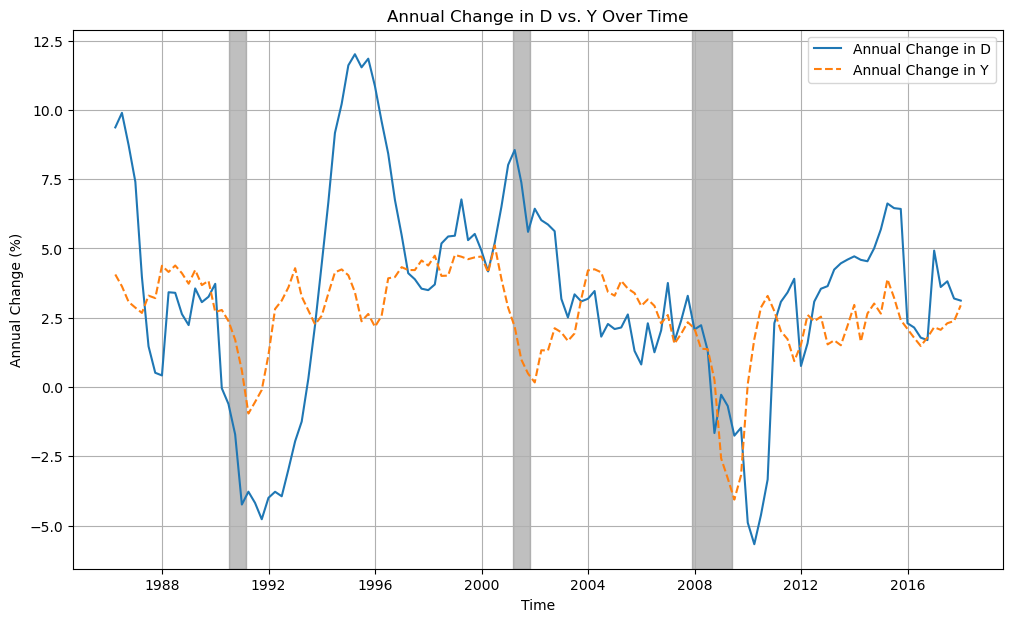

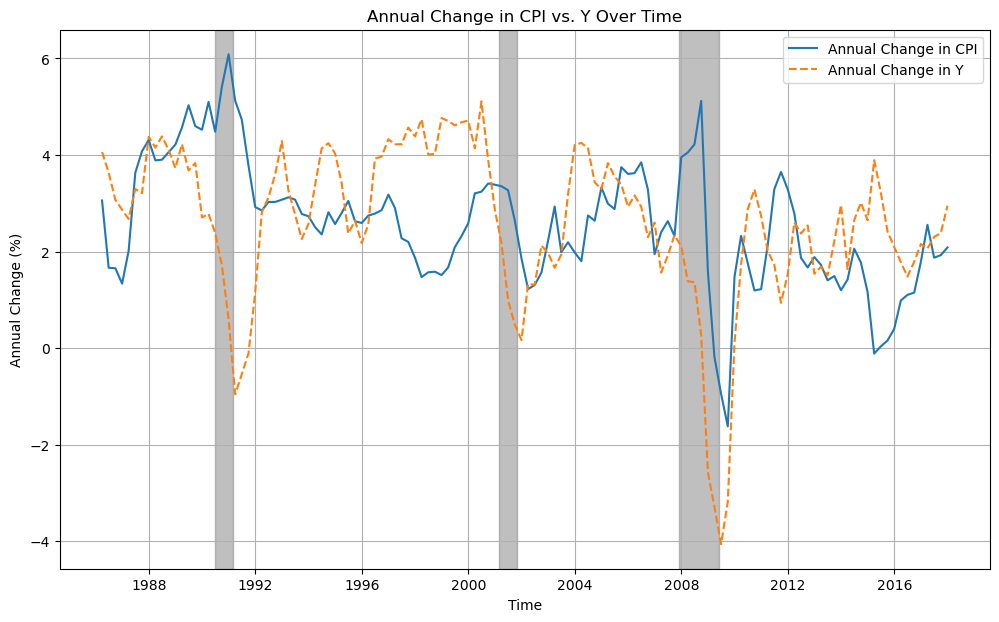

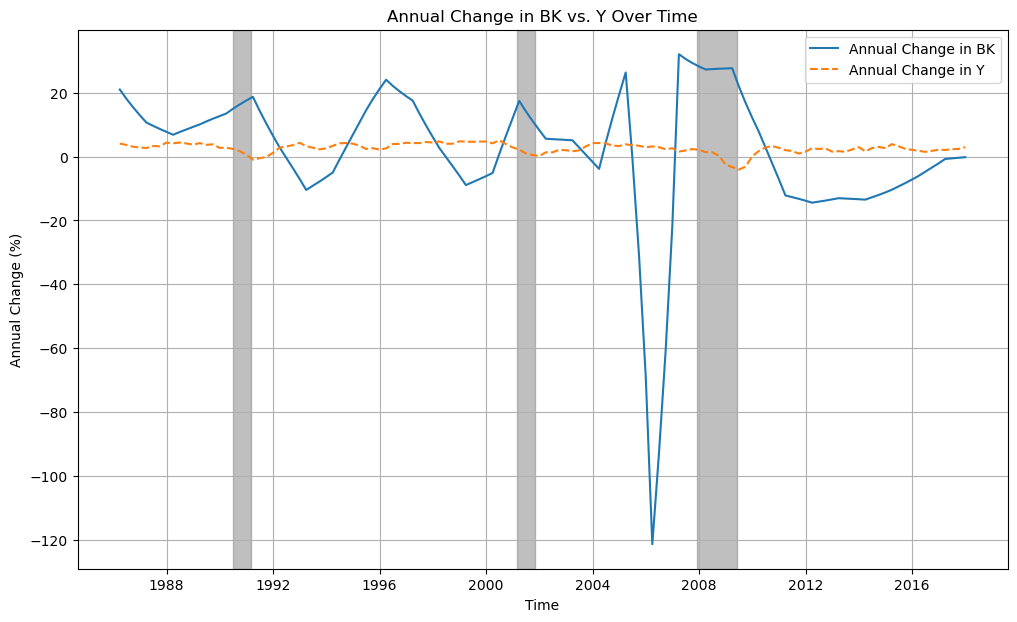

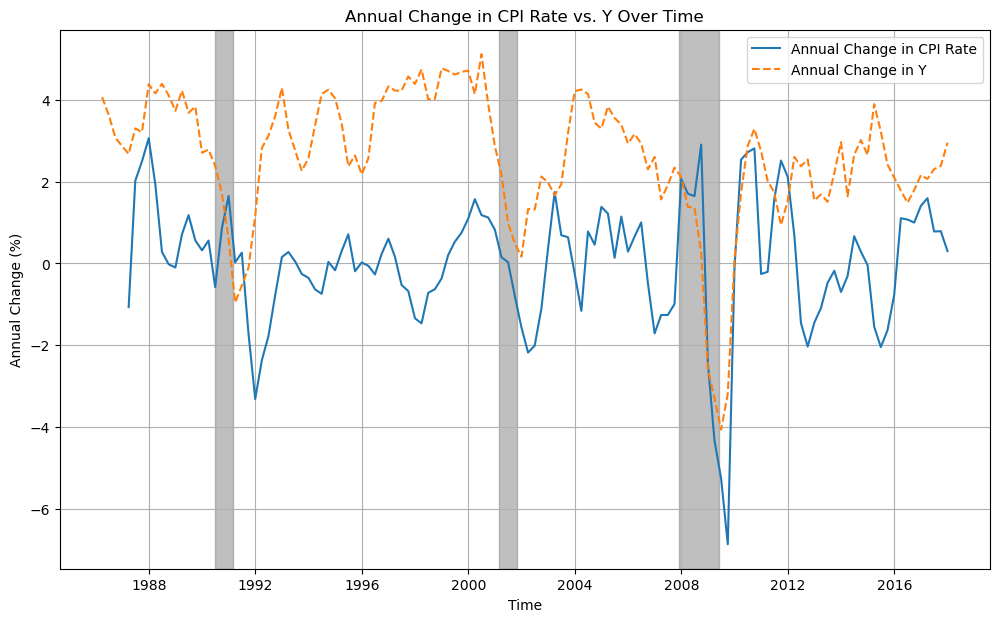

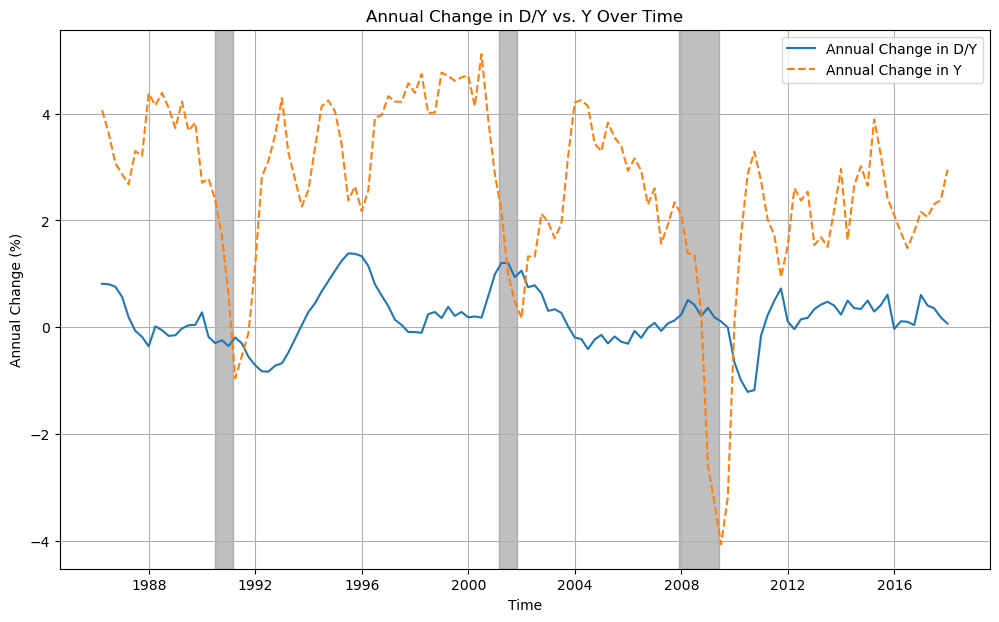

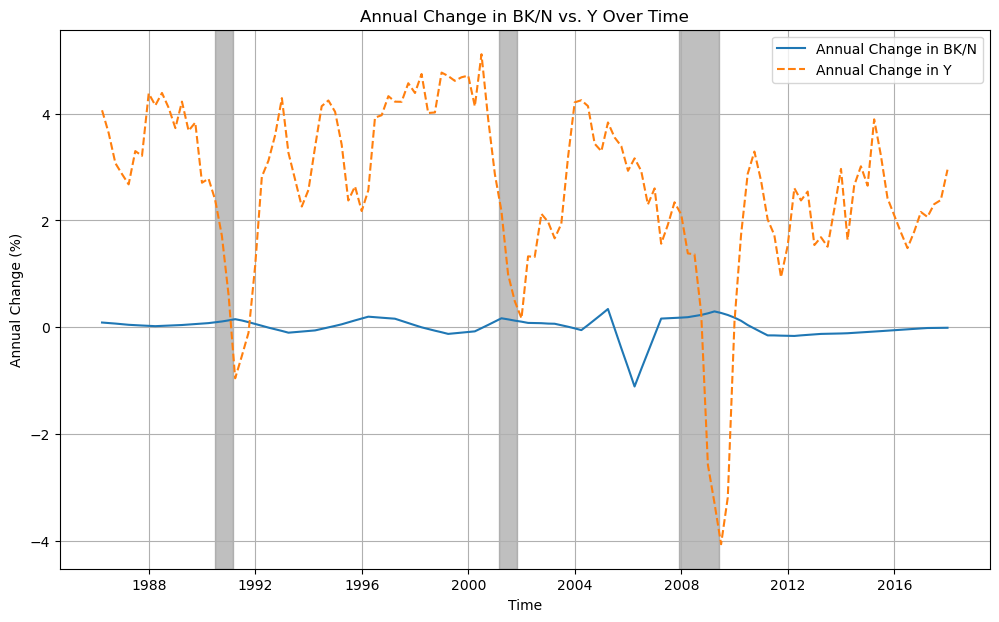

In [18]:
y_annual_change = 100*(np.log(series['Y']) - np.log(series['Y'].shift(4)))

def plot_annual_changes_with_Y(variable, data, save_path=None):
    plt.figure(figsize=(12, 7))
    plt.plot(data.index, data, label=f'Annual Change in {variable}', markersize=5)
    plt.plot(y_annual_change.index, y_annual_change, label='Annual Change in Y', linestyle='--')
    
    plt.title(f'Annual Change in {variable} vs. Y Over Time')
    plt.xlabel('Time')
    plt.ylabel('Annual Change (%)')
    plt.legend()
    plt.grid(True)

    for start, end in recession_periods:
        plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.5)

    if save_path:
        plt.savefig(save_path, format='png', dpi=300)  # Save the figure before showing it

    plt.show()

base_save_path = '/Users/alexwellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/'

selected_top_vars = ['D', 'CPI', 'BK']
selected_bottom_vars = ['CPI Rate', 'D/Y', 'BK/N']

# For selected top variables
for var in selected_top_vars:
    if var in series:  # Ensure the variable exists in the dataset
        data = 100 * (np.log(series[var]) - np.log(series[var].shift(4)))
        save_path = f'{base_save_path}{var}_annual_change_vs_Y.png'
        plot_annual_changes_with_Y(var, data.dropna(), save_path=save_path)

# For selected bottom variables
for var in selected_bottom_vars:
    if var in series:  
        data = series[var] - series[var].shift(4)
        safe_var_name = var.replace('/', '_')  # make sure filename is valid
        save_path = f'{base_save_path}{safe_var_name}_annual_change_vs_Y.png'
        plot_annual_changes_with_Y(var, data.dropna(), save_path=save_path)


## Annualized Quarterly

In [19]:
# Initialize an empty DataFrame for results
results_annualized_quarterly_change = pd.DataFrame(columns=['Variable', 'SD', 'Cor(y, x)', 'Cor(x, x_t-4)'])

for var in top_vars + bottom_vars:  # Combining top and bottom for iteration
    if var in top_vars:
        # Top variables: Compute 400 times the log difference over one quarter
        data = 400 * (np.log(series[var]) - np.log(series[var].shift(1)))
    else:
        # Bottom variables: Compute 4 times the simple difference over one quarter
        data = 4 * (series[var] - series[var].shift(1))
    
    y_q= 400 * (np.log(series['Y']) - np.log(series['Y'].shift(1)))
    sd = data.std()
    cor_y_x = data.corr(y_q)
    cor_x_xt_minus_1 = data.corr(data.shift(4))
    
    # Create a temporary DataFrame for the current variable's results
    temp_df = pd.DataFrame({
        'Variable': [var], 
        'SD': [sd], 
        'Cor(y, x)': [cor_y_x], 
        'Cor(x, x_t-4)': [cor_x_xt_minus_1]
    })
    
    # Use pd.concat to add the current variable's results to the results DataFrame
    results_annualized_quarterly_change = pd.concat([results_annualized_quarterly_change, temp_df], ignore_index=True)



In [20]:
results_annualized_quarterly_change


,Variable,SD,"Cor(y, x)","Cor(x, x_t-4)"
0,Y,2.309794,1.000000,0.123862
1,C,2.183265,0.571763,0.135983
2,G,3.123618,0.189874,0.350253
3,I,11.934354,0.743582,-0.033469
4,N,1.724548,0.610183,0.465577
5,D,4.871028,0.222268,0.342932
6,BG,5.940316,-0.358194,0.429672
7,W_manu,2.087480,-0.184237,-0.106601
8,W_manu_nominal,1.142436,0.010151,0.127852
9,tax,18.404837,0.246859,0.059629


Merge

In [21]:
# merge sections of the table

merged_results = pd.merge(combined_results, results_annual_change, on='Variable', how='outer', suffixes=('', '_bottom_filtered'))
merged_results = pd.merge(merged_results, results_annualized_quarterly_change, on='Variable', how='outer', suffixes=('', '_annualized_quarterly_change'))

all_vars_ordered = top_vars + bottom_vars

# Create an ordered categorical type for 'Variable' column
merged_results['Variable'] = pd.Categorical(merged_results['Variable'], categories=all_vars_ordered, ordered=True)

# Sort by 'Variable' to have top variables on top and bottom variables at the bottom
merged_results.sort_values('Variable', inplace=True)

# Reset index to clean up the DataFrame
merged_results.reset_index(drop=True, inplace=True)

# Define the MultiIndex for columns to indicate the source and measurement type
multi_index_tuples = [
    ('', 'Variable'), ('Combined', 'SD'), ('Combined', 'Cor(y, x)'), ('Combined', 'Cor(x, x_{t-4})'),
    ('Annual Change', 'SD'), ('Annual Change', 'Cor(y, x)'), ('Annual Change', 'Cor(x, x_{t-4})'),
    ('Annualized Quarterly Change', 'SD'), ('Annualized Quarterly Change', 'Cor(y, x)'), ('Annualized Quarterly Change', 'Cor(x, x_{t-4})'),
   
]

multi_index = pd.MultiIndex.from_tuples(multi_index_tuples, names=['Data', 'Measurement'])

merged_results.columns = multi_index

merged_results

Data                          Combined                            \
Measurement        Variable         SD Cor(y, x) Cor(x, x_{t-4})   
0                         Y   1.039871  1.000000        0.316756   
1                         C   0.927177  0.853016        0.330995   
2                         G   1.223552 -0.419897        0.467175   
3                         I   5.425434  0.893683        0.304236   
4                         N   1.104419  0.807605        0.521792   
5                         D   2.501638  0.240827        0.484924   
6                        BG   2.372258 -0.393554        0.372025   
7                    W_manu   0.788773 -0.448585        0.199296   
8            W_manu_nominal   0.458369 -0.514562        0.361013   
9                       tax   7.020075  0.718653        0.350213   
10                       BK  14.255680 -0.495734        0.213386   
11                 CO_level  18.124560 -0.559138        0.458538   
12                      CPI   0.711076  0.165906        0.122605   
13                      PCE   0.560575  0.276713        0.148640   
14                 CPI_rate   1.315480  0.398691        0.341219   
15                 PCE_rate   1.111097  0.393716        0.441089   
16                        i   2.841580  0.369623        0.875345   
17            Piw_manu_perc   0.812435 -0.032132        0.440907   
18                  CO_rate   1.050760 -0.399883        0.755138   
19                     BK/N   0.260121 -0.353061        0.729148   
20                     BG/Y  18.645876 -0.131001        0.982507   
21                      D/Y   2.046557  0.004393        0.968306   

Data        Annual Change                            \
Measurement            SD Cor(y, x) Cor(x, x_{t-4})   
0                1.625734  1.000000        0.301859   
1                1.499664  0.865457        0.407101   
2                1.994572 -0.038327        0.567938   
3                7.895003  0.836331        0.156581   
4                1.601870  0.786851        0.572733   
5                3.780019  0.381125        0.564507   
6                4.112934 -0.484136        0.524658   
7                1.246501 -0.240490        0.159699   
8                0.772517 -0.047376        0.489916   
9                9.520090  0.587089        0.182757   
10              20.817609 -0.185270        0.053129   
11              22.818891 -0.314923        0.343342   
12               1.282738  0.205164        0.338080   
13               1.087502  0.227454        0.436840   
14               1.525688  0.405613       -0.428655   
15               1.189921  0.446008       -0.406360   
16               1.404434  0.529490        0.265225   
17               0.852458 -0.021228       -0.289452   
18               0.736699 -0.400232        0.302295   
19               0.188290 -0.257051        0.042465   
20               3.412230 -0.725519        0.569416   
21               0.506901 -0.046706        0.380903   

Data        Annualized Quarterly Change                            
Measurement                          SD Cor(y, x) Cor(x, x_{t-4})  
0                              2.309794  1.000000        0.123862  
1                              2.183265  0.571763        0.135983  
2                              3.123618  0.189874        0.350253  
3                             11.934354  0.743582       -0.033469  
4                              1.724548  0.610183        0.465577  
5                              4.871028  0.222268        0.342932  
6                              5.940316 -0.358194        0.429672  
7                              2.087480 -0.184237       -0.106601  
8                              1.142436  0.010151        0.127852  
9                             18.404837  0.246859        0.059629  
10                            26.791765 -0.154230       -0.130953  
11                            50.281291 -0.133975        0.472213  
12                             1.995698  0.198520        0.050035  
13                        

## Save Table

In [22]:
# Round the numerical data in the DataFrame to three decimal places
rounded_merged_results = merged_results.round(3)

# Specify the file path where you want to save the LaTeX table
file_path = '/Users/alexwellman/Documents/SIEPR/GitHub/macrodata-wellman/check_t/table_expanded.tex'

# Export the rounded DataFrame as a LaTeX table
with open(file_path, 'w') as f:
    f.write(rounded_merged_results.to_latex(index=False, float_format="%.3f"))
